## Overview

In this notebook we will walk through the MNIST example and show how to use GPyOpt to tune a NN in PyTorch.

In [11]:
import sys
sys.path.append("..") # adds higher directory to python modules path
from GPyOpt.methods import BayesianOptimization
import GPyOpt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import torchvision
import numpy as np
from src import data_prep as dp
from src import models as m
from src import train as train
from src import utils as utils
from src import plotting as plotting
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

GeForce GTX 1080 Ti


## Prerequisites

The aim of this notebook is to provide a practical example of how to use GPyOpt for tuning a NN - not to motivate and introduce background concepts. However, as a minimum, it is helpful to be familiar with the following areas:

* Gaussian processes
* Acquisition functions
* Kernels
* Neural networks

## Parameters to optimize

With GPyOpt we can basically optimize most types of parameters, including discrete and categorical. This allows great flexibility when fitting a NN though I can't find any strong references backing this up (particularly the categorical) and so I'm unsure how well it will work in practice.

For MNIST, given it's a small and easy data-set and I'm using a GPU we will go for quite a large domain. A simpler case would be to fix the model architecture (e.g. use a pre-trained model) and just let GPyOpt tune the hyperparameters. It's worth noting that if we did grid search on 8 parameters (as we are below) and each of those parameters could take on just 4 values we'd have $4^8$ possible values to try. 

Here we are going to let the BO actually vary the model's capacity via `num_lay`, `num_c` and `num_fc` which control the number of layers in the CNN, the number of channels (doubled at each layer by default) and the size of the fully connected layer at the end.

Below is an example of how we specify this to GPyOpt.

In [3]:
opt_BO = [{'name': 'lr', 'type': 'continuous', 'domain': (0.05, 0.25)},
          {'name': 'mom', 'type': 'continuous', 'domain': (0.85, 0.95)},
          {'name': 'num_lay', 'type': 'discrete', 'domain': range(1, 4)},
          {'name': 'num_c', 'type': 'discrete', 'domain': range(8, 22, 2)},
          {'name': 'num_fc', 'type': 'discrete', 'domain': range(10, 105, 5)},
          {'name': 'dropout', 'type': 'discrete', 'domain': np.linspace(0, 0.4, 11)},
          {'name': 'bs', 'type': 'discrete', 'domain': range(64, 288, 32)},
          ]

## Model

Let's have a look at a simple CNN for MNIST. The model itself will be straightforward but we use a few neats aspects of PyTorch to allow us to vary the number of layers e.g. via `nn.ModuleList`

We are using a `kernel_size=5` so with the default values of `padding=0` and `stride=1` the feature map will reduce by 4 each time we call `ConvBnRelu`. We also opt for a convention of doubling the number of channels at each layer.

In [4]:
class ConvBnRelu(nn.Module):
    """Re-usable building block implementing 2d conv layer with batch-norm and relu activation"""
    def __init__(self, in_channels, out_channels, p):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=5),  # reduces feature map by 4
                                  nn.BatchNorm2d(out_channels),
                                  nn.Dropout2d(p=p, inplace=True),
                                  nn.ReLU(inplace=True)
                                  )

    def forward(self, x):
        return self.conv(x)

class FlexCNN(nn.Module):
    """Simple CNN with flexible capacity"""
    def __init__(self, n_lay=2, n_c=16, n_fc=25, dropout=0.1, hw=(28,28)):
        super().__init__()
        self.name = 'flex_cnn'
        self.init_args = {'n_lay':n_lay, 'n_c':n_c, 'n_fc':n_fc}  # for loading back model with correct size
        self.h, self.w = hw
        self.out_hw = self.h - (n_lay + 1) * 4
        self.out_c = n_c * (2 ** n_lay)
        self.convs = nn.ModuleList([ConvBnRelu(1, n_c, dropout)])
        self.convs.extend([ConvBnRelu((2 ** (i - 1)) * n_c, (2 ** i) * n_c, dropout) for i in range(1, n_lay + 1)])
        self.fc1 = nn.Linear(self.out_c * (self.out_hw ** 2), n_fc * 2)
        self.fc2 = nn.Linear(n_fc * 2, 10)

    def forward(self, x):
        bs = x.shape[0]
        x = x.view(-1, 1, self.h, self.w)
        for i, l in enumerate(self.convs):
            x = self.convs[i](x)
        x = x.view(bs, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Let's instantiate the model and take a look:

In [5]:
model = m.FlexCNN()
model

FlexCNN(
  (convs): ModuleList(
    (0): ConvBnRelu(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout2d(p=0.1, inplace)
        (3): ReLU(inplace)
      )
    )
    (1): ConvBnRelu(
      (conv): Sequential(
        (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout2d(p=0.1, inplace)
        (3): ReLU(inplace)
      )
    )
    (2): ConvBnRelu(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout2d(p=0.1, inplace)
        (3): ReLU(inplace)
      )
    )
  )
  (fc1): Linear(in_features=16384, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias

## Objective function

It's actually fairly simple to get up and running with GPyOpt. The main function (and work) is to create an objective function that GPyOpt will either minimize or maximize.

The function doesn't need to do the data-loading unless parameters we wish to vary are part of the data-loading process (e.g. batch size).

Below we show a simple function that wraps up the data-loading and model fit. `WrapDL` is a simple class which applies a (pre-processing) function to each mini-batch as it is yielded by PyTorch.

We then instantiate and fit the model, passing in the parameters we wish to optimize over. The `train.fit` function takes a model and fits it for a given number of epochs.

In [15]:
@utils.call_counter
def f_opt_mnist(parameters):
    parameters = parameters[0]  # np.ndarray passed in is nested
    print(f'---------Starting Bay opt call {f_opt_mnist.calls} with parameters: ---------')
    utils.print_params(parameters, opt_BO)
    # Data loading:
    trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=dp.mnist_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=int(parameters[6]), shuffle=True, num_workers=8)
    testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=dp.mnist_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=int(parameters[6]), shuffle=False, num_workers=8)
    train_dl, valid_dl = dp.WrapDL(trainloader, dp.to_gpu), dp.WrapDL(testloader, dp.to_gpu)

    # Model definition:
    model = m.FlexCNN(n_lay=int(parameters[2]),
                        n_c=int(parameters[3]),
                        n_fc=int(parameters[4]),
                        dropout=parameters[5])
    model.to(dev)
    # Optimizer:
    opt = optim.SGD(model.parameters(), lr=parameters[0], momentum=parameters[1])
    scheduler = optim.lr_scheduler.CyclicLR(opt, parameters[0], parameters[0]*3,
                                            step_size_up=int(len(train_dl)*int(parameters[6])*epochs*0.25))
    # Fit:
    score = train.fit(epochs, model, loss_func, scheduler, train_dl, valid_dl, train.accuracy, model_folder)
    return np.array(score)

We still need to specify the loss function, as well as how many epochs and iterations to run the BO for, plus a few other general fitting settings:

In [19]:
plot = True
loss_func = F.cross_entropy
opt_func = f_opt_mnist
cleanup_models_dir = True  # will delete models from model_folder before running
model_folder = '../models/mnist/'
epochs = 4
max_iter = 2

We create a folder to store the models in after each BO has finished - this means we don't have to potentially re-train a large NN again after finding the best parameters

We are now ready to execute the main function call to `BayesianOptimization` and run for `max_iter` + 5 initial runs.

In [20]:
utils.setup_folders(model_folder) # create folders if don't exist
if cleanup_models_dir: utils.clean_folder(model_folder)  # delete models from previous runs
# GPyOpt function call:
optimizer = BayesianOptimization(f=opt_func,  # objective function
                 domain=opt_BO,
                 model_type='GP',
                 acquisition_type='EI',
                 normalize_Y=True,
                 acquisition_jitter=0.05,  # positive value to make acquisition more explorative
                 exact_feval=False,  # whether the outputs are exact
                 maximize=False,
                )
optimizer.run_optimization(max_iter=max_iter)  # 5 initial exploratory points + max_iter

Deleting models from: ../models/mnist/
---------Starting Bay opt call 3 with parameters: ---------
| lr: 0.13 | mom: 0.86 | num_lay: 2.00 | num_c: 8.00 | num_fc: 50.00 | dropout: 0.20 | bs: 128.00 |

e: 1, trn loss: 0.2429, val loss: 0.0706, val met: 0.9784
e: 2, trn loss: 0.0983, val loss: 0.0639, val met: 0.9798
e: 3, trn loss: 0.0785, val loss: 0.0566, val met: 0.9831
e: 4, trn loss: 0.0639, val loss: 0.0440, val met: 0.9860
---------Starting Bay opt call 4 with parameters: ---------
| lr: 0.21 | mom: 0.91 | num_lay: 3.00 | num_c: 8.00 | num_fc: 80.00 | dropout: 0.00 | bs: 128.00 |

e: 1, trn loss: 0.2211, val loss: 0.1003, val met: 0.9719
e: 2, trn loss: 0.0790, val loss: 0.0757, val met: 0.9778
e: 3, trn loss: 0.0573, val loss: 0.0533, val met: 0.9841
e: 4, trn loss: 0.0543, val loss: 0.0532, val met: 0.9845
---------Starting Bay opt call 5 with parameters: ---------
| lr: 0.23 | mom: 0.89 | num_lay: 1.00 | num_c: 12.00 | num_fc: 30.00 | dropout: 0.40 | bs: 160.00 |

e: 1, trn los

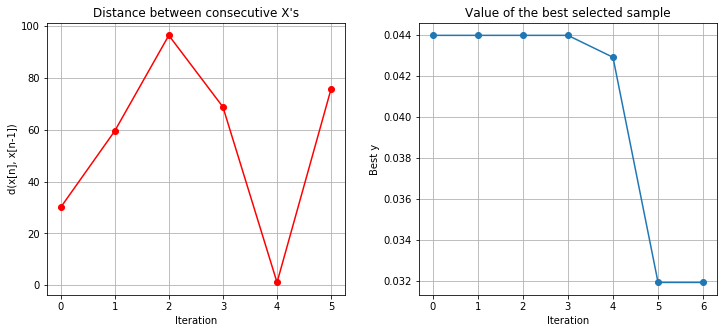

--------------------------------------------------
Optimal parameters from Bay opt are:
| lr: 0.05 | mom: 0.85 | num_lay: 3.00 | num_c: 16.00 | num_fc: 60.00 | dropout: 0.40 | bs: 128.00 |



In [21]:
if plot:
    plotting.plot_convergence(optimizer.X, optimizer.Y_best)
print('--------------------------------------------------')
print('Optimal parameters from Bay opt are:')
utils.print_params(optimizer.x_opt, opt_BO)

## Comment

I might turn the below into a separate blog post time permitting

#### Normal machine learning reporting of results
Depending on randomness the above reaches a validation accuracy of around 99% in 4 epochs with just a few runs.

#### What actually happened
_"It doesn't matter how beautiful your theory is, it doesn't matter how smart you are. If it doesn't agree with experiment, it's wrong."_

_"If science is to progress, what we need is the ability to experiment, honesty in reporting results—the results must be reported without somebody saying what they would like the results to have been—and finally—an important thing—the intelligence to interpret the results."_

It would be misleading people to present the above as though it worked first time out the box. Many times training diverged on me almost as much as it converged. This was predominantly because I had a desire to leave the domains for most parameter settings reasonably wide so as not to constrain the search too much by embedding lots of prior knowledge (after all, MNIST is a pretty overfit dataset and many scripts are online showing over 99% accuracy). 

This is clearly a tension that existed in creating this example...Bayesian frameworks allow the expression of prior knowledge but by guiding things too much on MNIST I'm going to overestimate the usefulness of BO for a new data-set I care more and know less about. 

If training on bigger datasets is several hours then wasted trials or divergence is a big issue*. 

So where does this leave us?

Well, we haven't talked about tuning the BO (via the GP kernel or exploration/exploitation trade-off) at all yet and it's here we get to a central criticism of BO, to quote [A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning](http://arxiv.org/abs/1012.2599):

"_A particular issue is that the design of the prior is absolutely critical to efficient Bayesian optimization. Gaussian processes are not always the best or easiest solution, but even when they are, great care must be taken in the design of the kernel. In many cases, though, little is known about the objective function, and, of course, it is expensive to sample from (or we wouldn’t need to use Bayesian optimization in the first place). The practical result is that in the absence of (expensive) data, either strong assumptions are made without certainty that they hold, or a weak prior must be used. It is also often unclear how to handle the trade-off between exploration and exploitation in the acquisition function. Too much exploration, and many iterations can go by without improvement. Too much exploitation leads to local maximization._

_These problems are exacerbated as dimensionality is increased—more dimensions means more samples are required to cover the space, and more parameters and hyperparameters may need to be tuned, as well. In order to deal with this problem effectively, it may be necessary to do automatic feature selection, or assume independence and optimize each dimension individually._"

#### TLDR

In it's current guise BO is unlikely to be something that provides a silver bullet for tuning NNs in the near future.

\*One might counter than no trial is wasted as it's information for the GP to reduce it's uncertainty and this is definitely true, however, too many poor trials can leave the experimenter wondering if the experiment itself is flawed rather than just the individual trial settings.